# Tutorial Part 1: Reading in AIM files

Author: *Dr. Danielle Whittier and Jilmen Quintiens*
<br>Created: *17 Jan 2024*
<br>Last Modified: *17 Jan 2024*

## Load necessary packages
vtkbone is the core tool used here for reading and writing .AIMs

In [1]:
import numpy as np
import vtk
import vtkbone
import SimpleITK as sitk
import matplotlib.pyplot as plt

In addition we will import some helper functions. These are found in the "/python_helpers" sub-folder and originally pulled from the Bone Lab Repositoty. 

The purpose of each is described in the code comments below:

In [19]:
#provides function to read AIM header (in standard format) and pull key values for density calibration
from python_helpers.aim_calibration_header import get_aim_calibration_constants_from_processing_log
from python_helpers.aim_calibration_header import get_aim_density_equation
from python_helpers.aim_calibration_header import get_aim_hu_equation

#provides functions for converting between vtk image data format to a numpy array and back
from python_helpers.vtk_util import vtkImageData_to_numpy, numpy_to_vtkImageData


## Read in AIM file

This step uses the vtkboneAIMReader() class from vtkbone. The details of this class, including a list of all member functions can be found in the documentation [here](https://www.numerics88.com/documentation/vtkbone/1.0/classvtkboneAIMReader.html)

In [3]:
#specify file path to image. here we use the example image found in the "/data" subfolder
file_path = "data/TRAB_1240.AIM"

# read in aim image
reader = vtkbone.vtkboneAIMReader()
reader.DataOnCellsOff() 
reader.SetFileName(file_path)
reader.Update()

#here we pull the image data itself along with the header information 
img_file = reader.GetOutput()
img_header = reader.GetProcessingLog()

### Pull information from AIM header 
Here an example is shown of how to pull origin and spacing (i.e. voxel size) using the vtkboneAIMReader member functions "GetOrigin()" and "GetSpacing()". These are the most commonly needed properties needed to correctly format your image, but there may be more depending on your use case. 

These are formatted into an array for correct interpretation later on.

In [4]:
img_origin = np.asarray(img_file.GetOrigin())
print("Origin coordinates pulled from the image data: ",img_file.GetOrigin())
print("Origin coordinates formatted as a np.array: ",img_origin)

img_spacing = np.asarray(img_file.GetSpacing())
print("Spacing pulled from the image data: ",img_file.GetSpacing())
print("Spacing formatted as a np.array: ",img_file.GetSpacing())

Origin coordinates pulled from the image data:  (60.73000270687044, 45.43369018100202, 12.71633768081665)
Origin coordinates formatted as a np.array:  [60.73000271 45.43369018 12.71633768]
Spacing pulled from the image data:  (0.06069965288043022, 0.06069965288043022, 0.060698509216308594)
Spacing formatted as a np.array:  (0.06069965288043022, 0.06069965288043022, 0.060698509216308594)


## Convert to numpy array
This uses the helper function that we loaded at the beginning of the notebook:

In [5]:
np_image = vtkImageData_to_numpy(img_file)

#printing out a few checks to show the data dimensions are the same, but the data format is different 
print("Dimensions of vtk image: ", img_file.GetDimensions())
print("Dimensionts of np image array: ", np.shape(np_image))

Dimensions of vtk image:  (108, 108, 126)
Dimensionts of np image array:  (108, 108, 126)


We can even do a basic visualization with matlibplot:

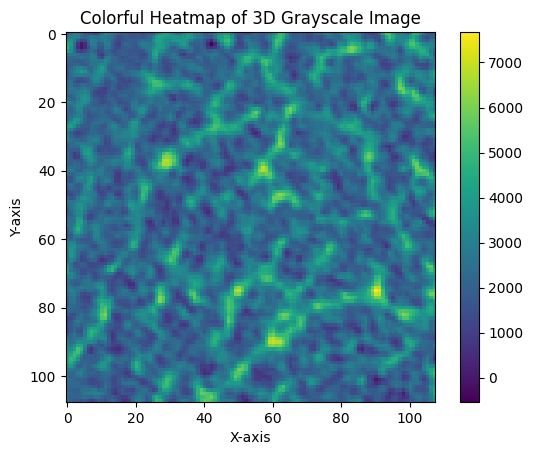

In [6]:
# Select the slice you want to visualize (you can change the index)
slice_index = 10
selected_slice = np_image[:, :, slice_index]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the selected slice as a heatmap
heatmap = ax.imshow(selected_slice, cmap='viridis')

# Add colorbar to the right of the plot
cbar = plt.colorbar(heatmap, ax=ax)

# Set labels and title
ax.set_title('Colorful Heatmap of 3D Grayscale AIM Image')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.show()

## Convert image units
From the plot you'll notice the image units are not meaningful. This is because they are in native Scanco units. We can convert the units to density (mg HA/ccm), linear attenuation (1/mm), or Hounsfield Units (unitless) so that they are more meaningful to work with.

In [7]:
#first get the image calibration information from the image header. 
#This is done using the helper function provided, so long as the header is formatted in the standard Scanco format
mu_scaling, hu_mu_water, hu_mu_air, density_slope, density_intercept = get_aim_calibration_constants_from_processing_log(img_header)

### Convert to Linear Attenuation

In [12]:
#simple step to scale to linear attenuation with mu scaling value
np_image_lin_atten = np_image/mu_scaling

#print some outputs to show that it is changed
print("Image converted to linear attenuation")
print("Raw image data mean: ", np.mean(np_image), "[native]")
print("converted image data mean in linear attenuation: ", np.mean(np_image_lin_atten), "[1/cm]")

Image converted to linear attenuation
Raw image data mean:  2492.4075264822436 [native]
converted image data mean in linear attenuation:  0.3042489656350395 [1/cm]


### Convert to Density

In [25]:
#the calibration equation is a linear function (y=mx+b), 
#where the slope and intercept for density are calucalted from the image header with the helper function

#get values
m_dens,b_dens = get_aim_density_equation(img_header)
# convert image to density
np_image_density = np_image * m_dens + b_dens


#print some outputs to show that it is changed
print('Image converted to density')
print("Raw image data mean: ", np.mean(np_image), "[native]")
print("Converted image data mean in density: ", np.mean(np_image_density), "[mg HA/ccm]")

Image converted to density
Raw image data mean:  2492.4075264822436 [native]
Converted image data mean in density:  107.21221355587663 [mg HA/ccm]


### Convert to Hounsfield Units

In [29]:
#the calibration equation is a linear function (y=mx+b), 
#where the slope and intercept for HU are calucalted from the image header with the helper function

#get values
m_hu,b_hu = get_aim_density_equation(img_header)
# convert image to Hounfield Units
np_image_hu = np_image * m_hu + b_hu

#print some outputs to show that it is changed
print('Image converted to Hounsfield Units')
print("Raw image data mean: ", np.mean(np_image), "[native]")
print("Converted image data mean in HU: ", np.mean(np_image_hu), "[unitless]")

Image converted to Hounsfield Units
Raw image data mean:  2492.4075264822436 [native]
Converted image data mean in HU:  107.21221355587663 [unitless]


In [ ]:
def aim_to_sitk(file_path, scaling, WRITE_MHA=False):
    
    # read in aim image
    reader = vtkbone.vtkboneAIMReader()
    reader.DataOnCellsOff()
    reader.SetFileName(file_path)
    reader.Update()
    img_file = reader.GetOutput()
    img_log = reader.GetProcessingLog()
    
    #convert to numpy array for scaling
    np_image = vtkImageData_to_numpy(img_file)
    
    if scaling is 'mu':
        #get calibration information from AIM processing log
        mu_scaling, hu_mu_water, hu_mu_air, density_slope, density_intercept = get_aim_calibration_constants_from_processing_log(img_log)
        np_image_scaled = np_image/mu_scaling
        print("image converted to linear attenuation")
    
    elif scaling is 'HU':
        #get calibration information from AIM processing log
        mu_scaling, hu_mu_water, hu_mu_air, density_slope, density_intercept = get_aim_calibration_constants_from_processing_log(img_log)
        m, b = get_aim_hu_equation(img_log)
        np_image_scaled = (np_image*m)+b
        print("image converted to linear attenuation")
        
    elif scaling is 'BMD':
        #get calibration information from AIM processing log
        mu_scaling, hu_mu_water, hu_mu_air, density_slope, density_intercept = get_aim_calibration_constants_from_processing_log(img_log)
        np_image_scaled = np_image/mu_scaling * density_slope + density_intercept
        print('image converted to bone mineral density')
    
    elif scaling is 'none': 
        np_image_scaled = np_image
        print("image values are unchanged")   
    
    else:
        raise ValueError(f'{scaling} is not a valid scaling option. Enter with \'HU\', \'mu\', \'BMD\' or \'none\'')
    
    # convert to SimpleITK image class
    origin = np.asarray(img_file.GetOrigin())
    spacing = np.asarray(img_file.GetSpacing())
    
    # #vtk and itk have their x and z axes flipped
    # origin[0], origin[2] = origin[2], origin[0]
    # spacing[0], spacing[2] = spacing[2], spacing[0]
    np_image_scaled = np.transpose(np_image_scaled)
        
    sitk_img = sitk.GetImageFromArray(np_image_scaled)
    sitk_img.SetOrigin(origin)
    sitk_img.SetSpacing(spacing)
    
    if WRITE_MHA:
        folder = os.path.dirname(file_path)
        file = os.path.basename(file_path).split('.')[0]
        out_path = os.path.join(folder, f'{file}.mha')
        print(f'Writing image to {out_path}')
        sitk.WriteImage(sitk_img, out_path)
    
    return sitk_img